# Uma Heurística GRASP para o Problema da Mochila Quadrática 0-1
O problema da mochila quadrática 0-1 (QKP) consiste em maximizar uma função objetivo quadrática sujeita a uma restrição linear, onde as variáveis são binárias (0 ou 1). Ele possui aplicações em diversas áreas, como finanças (alocação de recursos e seleção de carteira de ações) e seleção de projetos independentes. Formalmente: 

Maximizar: 

    Z = XᵀQX = ∑∑ qᵢⱼxᵢxⱼ 

Sujeito a: 

    ∑ aᵢxᵢ ≤ b xᵢ ∈ {0, 1} para todo i

Onde: 

- Q = (qᵢⱼ) é uma matriz n×n de coeficientes de "lucro" (definida positiva) 
- a = (aᵢ) é um vetor de pesos/capacidades 
- b é a capacidade total da mochila 
- xᵢ indica se o item i está (1) ou não (0) na mochila

Este problema é classificado como NP-Hard, o que significa que encontrar soluções exatas para instâncias maiores é computacionalmente inviável. Diante dessa dificuldade, o artigo propõe uma heurística GRASP (Greedy Randomized Adaptive Search Procedure) para resolvê-lo em sua formulação QKP1, que não será abordada neste trabalho.


---

In [82]:
# ---------------------------- DEPENDENCIES ----------------------------
import random
import numpy as np
from numpy.random import Generator, PCG64
import matplotlib.pyplot as plt
import seaborn as sns

In [83]:
# ---------------------------- CONFIG ----------------------------
# Semente para reprodutibilidade
seed = 42
rng = Generator(PCG64(seed))

# Número de itens
n = 30  

# Matriz de lucros (simétrica e definida positiva para garantir validade)
Q = rng.uniform(0, 10, size=(n, n))
Q = (Q + Q.T) / 2  # Torna simétrica
np.fill_diagonal(Q, rng.uniform(5, 15, n))  # Lucros individuais maiores

# Pesos dos itens (valores inteiros)
a = rng.integers(1, 10, n)

# Capacidade máxima (ajustada para ~30-50% do peso total)
b = int(np.sum(a) * 0.4)  # 40% da soma dos pesos

In [84]:
# ---------------------------- VALIDAÇÃO ----------------------------
print("Configuração gerada:")
print(f"- Número de itens (n): {n}")
print(f"- Capacidade (b): {b} (soma dos pesos = {np.sum(a)})")
print(f"- Peso dos itens (a): {a}")
print(f"- Matriz Q (exemplo 3x3):\n{Q[:3, :3]}")

Configuração gerada:
- Número de itens (n): 30
- Capacidade (b): 54 (soma dos pesos = 135)
- Peso dos itens (a): [7 3 8 4 8 4 1 7 1 7 1 2 6 9 4 2 3 9 7 1 4 3 2 8 6 2 6 4 1 5]
- Matriz Q (exemplo 3x3):
[[9.68416641 5.91820298 7.63500441]
 [5.91820298 7.5943984  3.98460782]
 [7.63500441 3.98460782 5.45173117]]


## Algoritmo Evolutivo Selecionado
Por se tratar de um problema com variáveis binárias, o **Algoritmo Genético Tradicional** com **Codificação Binária** consegue lidar bem com o problema, desde que tenha uma boa função de aptidão. Ademais, este algoritmo consegue explorar eficientemente o espaço de busca de soluções binárias cheio de ótimos locais, além de incorporar facilmente a restrição de capacidade.

Para as partes desse algoritmo, definimos:
- **Representação de um Indivíduo**: vetor binário de tamanho n;
- **Função de Aptidão**: XᵀQX, se aᵀX ≤ b;  XᵀQX − λ × max(0, Σ aᵢxᵢ − b), se aᵀX > b 
- **Cruzamento**: Torneio Binário
- **Recombinação**: Crossover Uniforme
- **Mutação**: Bit-Flip (verificando viabilidade)
- **Sobrevivência**: (μ + λ)


In [ ]:
# ---------------------------- AUX FUNCTIONS ----------------------------

# Gera um array aleatório de tamanho n com 0s e 1s (tanto faz)
def random_individual():
    return np.random.randint(0, 2, n)

# Verifica se o indíviduo gerado respeita o limite de capacidade da mochila
def is_viable(individual, weights, capacity):
    total_weight = np.sum(individual * weights)
    return total_weight <= capacity

# Gera um array aleatório de tamanho n com 0s e 1s (viavel)
def random_individual_viable(weights, profit_matrix, capacity):
    new_individual = np.random.randint(0, 2, n)

    if is_viable(new_individual, weights, capacity):
        return new_individual
    
    while (is_viable(new_individual, weights, capacity) == False):
        new_individual = mutation(new_individual, profit_matrix=profit_matrix, weights=weights, capacity=capacity)

    return new_individual

# Calcula o valor de aptidão de um indivíduo
def check_fitness(individual, profit_matrix):
    individual = np.asarray(individual)
    profit_matrix = np.asarray(profit_matrix)

    assert individual.ndim == 1, "Individual deve ser vetor 1D"
    assert profit_matrix.ndim == 2, "Matriz de lucro deve ser 2D"
    assert profit_matrix.shape[0] == profit_matrix.shape[1], "Matriz deve ser quadrada"
    assert profit_matrix.shape[0] == individual.shape[0], "Tamanhos incompatíveis"
    
    n = len(individual)
    fitness = 0.0
    for i in range(n):
        for j in range(n):
            # XᵀQX
            fitness += individual[i] * profit_matrix[i][j] * individual[j]
    return fitness

# Calcula a aptidão do indivíduo, aplicando penalidade de peso
def calc_fitness(individual, profit_matrix, weights, capacity, penalty=1000):
    # calculating fitness without considering the weight limit
    fitness = check_fitness(individual, profit_matrix) # XᵀQX, if aTx ≤ b
    # now checking the capacity
    excess = np.sum(individual * weights) - capacity
    # if excessing then it's over for the betinha
    # penalty is really high so it will be unlikely to be selected to reproduce
    if excess > 0:
        fitness -= penalty * excess # XᵀQX - λ × max(0, ∑aᵢxᵢ - b), if aTx > b

    return fitness

# Faz a recombinação/cruzamento dos pais (Crossover Uniforme)
def crossover(parent1, parent2, num_children=2):
    # print("\ncrossover")
    # considering the (μ + λ) approach
    children = []
    for _ in range(num_children):
        child = []
    # basically 50/50 chance to choose one gene from one parent
    # if pick is 0, then will receive gene from parent1, parent2 otherwise
        for gene in range(len(parent1)):
            pick = random.uniform(0, 1)
            if pick < 0.5:
                child.append(parent1[gene])
            else:
                child.append(parent2[gene])

        children.append(child)

    return children

# Conserta viabilidade testando qual melhor configuração para o indivíduo
def fix_viability(individual, profit_matrix, weights, capacity):
    individual = individual.copy()
    
    def weight(ind): return np.sum(ind * weights)
    def fitness(ind): return calc_fitness(ind, profit_matrix=profit_matrix, weights=weights, capacity=capacity)

    while weight(individual) > capacity:
        benefits = []
        for i, gene in enumerate(individual):
            if gene == 1:
                ind_copy = individual.copy()
                ind_copy[i] = 0
                delta = fitness(individual) - fitness(ind_copy)
                benefits.append((delta / weights[i], i))

        if benefits:
            _, worst_item = min(benefits, key=lambda x: x[0])
            individual[worst_item] = 0
        else:
            break

    return individual

# Faz a mutação de um indivíduo (Bit-Flip)
def mutation(individual, profit_matrix, weights, capacity):
    # print("\nmutacao")
    final = individual
    # choosing a random position from the individual array
    i = np.random.randint(len(final))
    # just flipping the bit (since it's 0 or 1 just doing it works just  fine)
    final[i] = 1 - final[i]

    if is_viable(final, weights=weights, capacity=capacity):
        return final
    
    else:
        fix_viability(final, profit_matrix, weights, capacity)
    
    return final
    
# Faz a seleção para cruzamento (Torneio Binário)
def tournament_selection(population, profit_matrix, weights, capacity, k=2):
    # print("torneio\n")
    
    competitors = random.sample(population, k)

    def fitness(ind): return calc_fitness(ind, profit_matrix=profit_matrix, weights=weights, capacity=capacity)

    fitnesses = [fitness(ind) for ind in competitors]

    max_fitness = max(fitnesses)
    best_indices = [i for i, fit in enumerate(fitnesses) if fit == max_fitness]

    winner_index = random.choice(best_indices)

    return competitors[winner_index]

# Seleção para sobrevivência (μ + λ)
def surviving_selection(population_parents, population_children, N, profit_matrix, weights, capacity,):
    # print("\nsobrevivencia")
    # putting them together
    pop_total = population_parents + population_children

    def fitness(ind): return calc_fitness(ind, profit_matrix=profit_matrix, weights=weights, capacity=capacity)
    
    # calc fitnesses for everyone
    fitnesses_parents = [fitness(ind) for ind in population_parents]
    fitnesses_children = [fitness(ind) for ind in population_children]

    # putting fitnesses together again
    fit_total = fitnesses_parents + fitnesses_children

    # joining everyone
    pairs = list(zip(pop_total, fit_total))

    # ordering them according to their aptitude
    ord_pairs = sorted(pairs, key=lambda x: x[1], reverse=True)

    # getting the best N dudes
    best_dudes = ord_pairs[:N]

    # separating values
    new_pop = [ind for ind, fit in best_dudes]
    new_fitnesses = [fit for ind, fit in best_dudes]

    return new_pop, new_fitnesses

# Busca gulosa para tentar melhorar o lucro
def local_search_repair(individual, profit_matrix, weights, capacity):
    individual = np.array(individual, dtype=int).copy()
    n = len(individual)
    
    def current_weight():
        return np.dot(individual, weights)
    
    def current_profit():
        return individual @ profit_matrix @ individual
    
    current_fitness = current_profit() if current_weight() <= capacity else -np.inf
    
    improved = True
    while improved:
        improved = False
        
        if current_weight() < capacity:
            not_selected = np.where(individual == 0)[0]
            for i in not_selected:
                marginal_profit = profit_matrix[i, i] + 2 * np.sum(profit_matrix[i, individual == 1])
                
                if current_weight() + weights[i] <= capacity and marginal_profit > 0:
                    individual[i] = 1
                    current_fitness += marginal_profit
                    improved = True
                    break 
        
        if not improved:
            selected = np.where(individual == 1)[0]
            for i in selected:
                marginal_loss = profit_matrix[i, i] + 2 * np.sum(profit_matrix[i, individual == 1])
                
                if marginal_loss < 0:
                    individual[i] = 0
                    current_fitness -= marginal_loss
                    improved = True
                    break

        if not improved:
            selected = np.where(individual == 1)[0]
            not_selected = np.where(individual == 0)[0]
            
            for out_item in selected:
                for in_item in not_selected:

                    if current_weight() - weights[out_item] + weights[in_item] > capacity:
                        continue

                    loss = profit_matrix[out_item, out_item] + 2 * np.sum(profit_matrix[out_item, individual == 1])
                    gain = profit_matrix[in_item, in_item] + 2 * np.sum(profit_matrix[in_item, individual == 1])
                    adjustment = -2 * profit_matrix[out_item, in_item]
                    
                    net_change = gain - loss + adjustment
                    
                    if net_change > 0:
                        individual[out_item] = 0
                        individual[in_item] = 1
                        current_fitness += net_change
                        improved = True
                        break
                if improved:
                    break
    
    return individual

In [86]:
# ---------------------------- ALGORITHM ----------------------------
def genetic_algorithm(pop_size, num_generations, profit_matrix, weights, capacity, crossover_prob, mutation_prob):
    part = int(pop_size * 0.1)

    def fitness(ind): return calc_fitness(ind, profit_matrix=profit_matrix, weights=weights, capacity=capacity)

    # Inicialização da população
    population_random = [random_individual() for _ in range(pop_size - part)]
    population_viable = [random_individual_viable(weights, profit_matrix, capacity) for _ in range(part)]
    population = population_random + population_viable

    best_fits_per_generation = []
    avg_fits_per_generation = []
    viabilidade_por_geracao = []    

    gen_best_improved = []
    best_fit_improved = 0
    best_individual = max(population, key=lambda ind: fitness(ind))
    best_fit = fitness(best_individual)
    print(f"📍 Inicialmente: Melhor solução: {best_individual}\nAptidao = {best_fit:.2f}")

    # Evolução
    for generation in range(num_generations):
        # print(f"Geração {generation}\n")
        k_tournament = min(5, 2 + generation // (num_generations // 4))
        fitnesses = [fitness(ind) for ind in population]
        new_population = []

        while len(new_population) < pop_size:
            p1 = tournament_selection(population, profit_matrix, weights, capacity, k_tournament)
            p2 = tournament_selection(population, profit_matrix, weights, capacity, k_tournament)

            if random.random() < crossover_prob:
                children = crossover(p1, p2)
                for child in children:
                    if random.random() < mutation_prob:
                        child = mutation(child, profit_matrix, weights, capacity)
            else:
                children = [p1, p2]

            new_population.extend(children)

        population, fitnesses = surviving_selection(population, new_population, pop_size, profit_matrix, weights, capacity)

        # Atualização do melhor indivíduo
        gen_best = max(population, key=lambda ind: fitness(ind))
        gen_best_fit = fitness(gen_best)

        generation += 1
        # Coleta de métricas
        fitnesses = [fitness(ind) for ind in population]
        best_fits_per_generation.append(max(fitnesses))
        avg_fits_per_generation.append(np.mean(fitnesses))
        
        # Viabilidade
        viaveis = sum(1 for ind in population if sum(weights[i] for i in range(n) if ind[i] == 1) <= capacity)
        viabilidade_por_geracao.append(100 * viaveis / pop_size)

        if gen_best_fit > best_fit:
            best_individual = gen_best
            best_ind_readable = list(map(int, best_individual))
            best_fit = gen_best_fit
            print(f"⭐ Geração {generation}: Melhor solução: x = {best_ind_readable}\nf(x) = {best_fit}")

            gen_best_improved = local_search_repair(best_individual, profit_matrix, weights, capacity)
            best_fit_improved = fitness(gen_best_improved)
            gen_best_improved = list(map(int, gen_best_improved))
            print(f"🔸 Solução melhorada: x = {gen_best_improved}\nf(x) = {best_fit_improved}")

    return (best_individual, best_fit, gen_best_improved, best_fit_improved, generation, best_fits_per_generation, avg_fits_per_generation, viabilidade_por_geracao)


### Execução
Para o algoritmo genético, é necessário também fazer a definição de alguns parâmetros de execução. Nesse caso, a **condição de parada** é dada pelo número máximo de **gerações** alcançado. Além disso, definimos também um número de **execuções** para fins comparativos. Outros parâmetros para definição seriam:
- **Tamanho da População**: define o número máximos de indivíduos (p) a persistirem em uma população (inicialmente e na sobrevivência);
- **Probabilidade de Crossover**: define as chances de ocorrer reprodução entre dois indivíduos em uma população (geralmente alta);
- **Probabilidade de Mutação**: define as chances de ocorrer mutação em um indivíduo gerado em uma população (geralmente baixa).

In [87]:
# ---------------------------- MAIN ----------------------------
p_size = 150
n_gen = 50
c_prob = 0.8
m_prob = 0.2

num_exec = 35
results = []

for i in range(num_exec):
    print(f"Execução {i}")
    best_individual, best_fit, best_improved, fit_improved, generation, best_fits_per_generation, avg_fits_per_generation, viabilidade_por_geracao = genetic_algorithm(pop_size=p_size, num_generations=n_gen, profit_matrix=Q, weights=a, capacity=b, crossover_prob=c_prob, mutation_prob=m_prob)
    results.append((generation, best_individual, best_fit, best_improved, fit_improved))
    print("\n")

best_of_all =  max(results, key=lambda tup: tup[2])
print(f"🏆Geração {best_of_all[0]}\nMelhor de todas as execuções: f(x) = {best_of_all[2]}\nIndivíduo: {list(map(int, best_of_all[1]))}")
print(f"🔨 Melhorado: f(x) = {best_of_all[4]}\nIndivíduo: {best_of_all[3]}")

Execução 0
📍 Inicialmente: Melhor solução: [0 1 1 0 0 1 0 0 1 0 1 1 0 0 1 1 1 0 0 1 0 0 0 1 1 1 0 1 1 0]
Aptidao = 1155.59
⭐ Geração 1: Melhor solução: x = [0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0]
f(x) = 1218.3448314411644
🔸 Solução melhorada: x = [1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0]
f(x) = 1789.038133037536
⭐ Geração 3: Melhor solução: x = [1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0]
f(x) = 1218.4596621896428
🔸 Solução melhorada: x = [1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]
f(x) = 1618.760233524517
⭐ Geração 4: Melhor solução: x = [0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0]
f(x) = 1356.9106952203422
🔸 Solução melhorada: x = [1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0]
f(x) = 1777.7987363355853
⭐ G

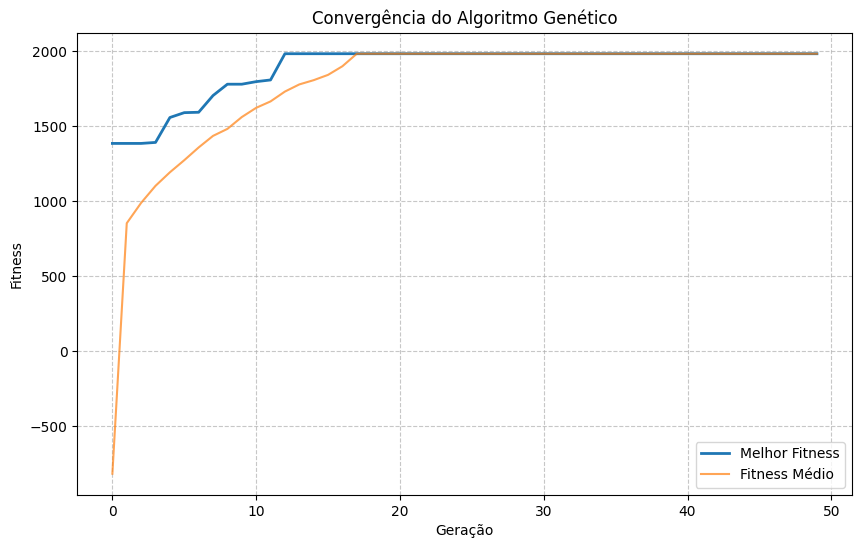

In [88]:
# ------------------------- GRAFICOS -----------------------------
# Curva de Convergência
plt.figure(figsize=(10, 6))
plt.plot(best_fits_per_generation, label='Melhor Fitness', linewidth=2)
plt.plot(avg_fits_per_generation, label='Fitness Médio', alpha=0.7)
plt.xlabel('Geração')
plt.ylabel('Fitness')
plt.title('Convergência do Algoritmo Genético')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

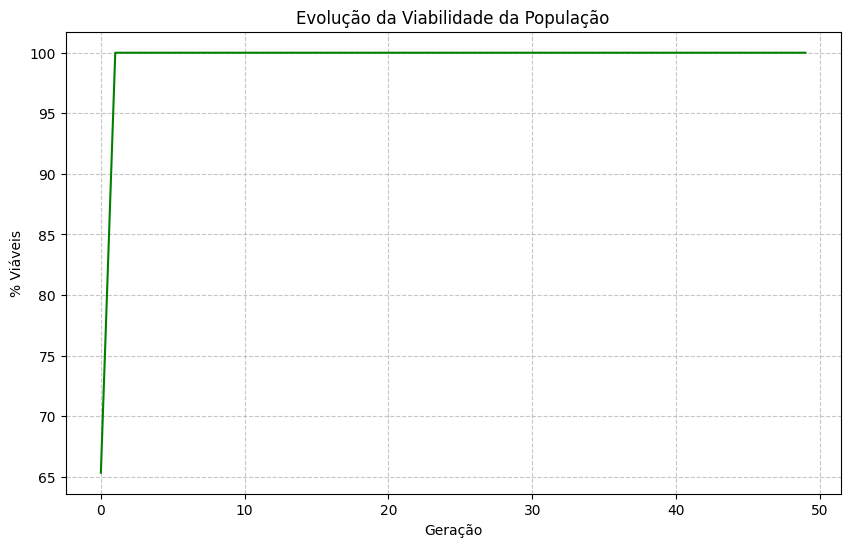

In [89]:
# Proporção de Indivíduos Viáveis por Geração
plt.figure(figsize=(10, 6))
plt.plot(viabilidade_por_geracao, color='green')
plt.xlabel('Geração')
plt.ylabel('% Viáveis')
plt.title('Evolução da Viabilidade da População')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

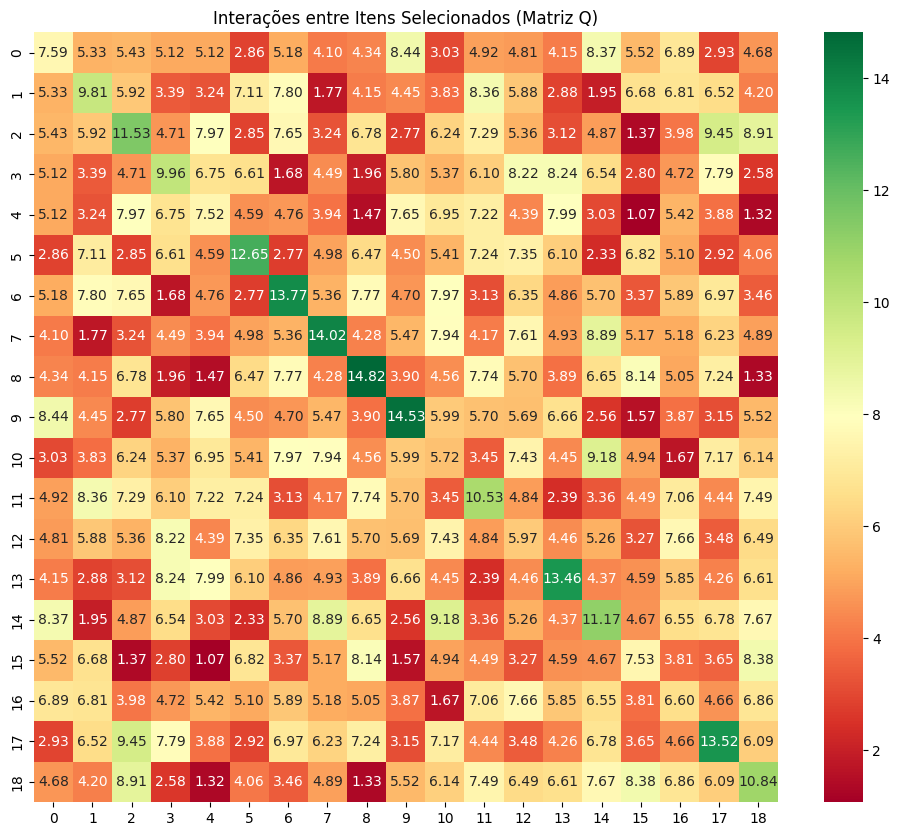

In [91]:
# Melhor solução final
solucao = np.array(best_of_all[1])  # ou np.array(best_improved)
itens_selecionados = np.where(solucao == 1)[0]

# Submatriz de Q com itens selecionados
Q_sub = Q[itens_selecionados][:, itens_selecionados]

plt.figure(figsize=(12, 10))
sns.heatmap(Q_sub, annot=True, fmt='.2f', cmap='RdYlGn')
plt.title('Interações entre Itens Selecionados (Matriz Q)')
plt.show()

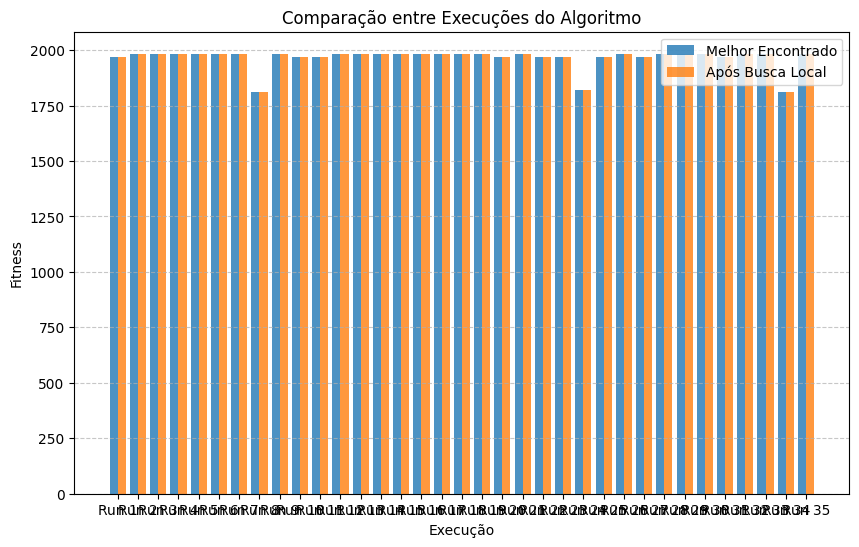

In [92]:
# Comparação entre Execuções
finais = [result[2] for result in results]  # best_fit de cada execução
melhorados = [result[4] for result in results]  # fit_improved

x_pos = np.arange(len(finais))
plt.figure(figsize=(10, 6))
plt.bar(x_pos - 0.2, finais, 0.4, label='Melhor Encontrado', alpha=0.8)
plt.bar(x_pos + 0.2, melhorados, 0.4, label='Após Busca Local', alpha=0.8)
plt.xlabel('Execução')
plt.ylabel('Fitness')
plt.title('Comparação entre Execuções do Algoritmo')
plt.xticks(x_pos, [f'Run {i+1}' for i in range(len(finais))])
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7, axis='y')
plt.show()

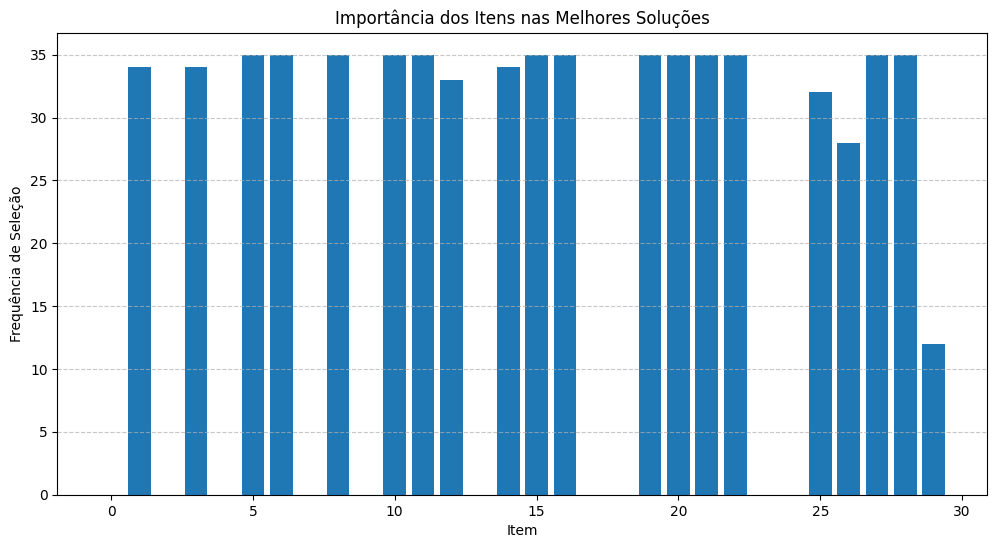

In [93]:
# Contar a frequência de seleção de cada item nas melhores soluções
contagem_itens = np.zeros(n)
for result in results:
    solucao = result[1]  # best_individual
    contagem_itens += solucao

plt.figure(figsize=(12, 6))
plt.bar(range(n), contagem_itens)
plt.xlabel('Item')
plt.ylabel('Frequência de Seleção')
plt.title('Importância dos Itens nas Melhores Soluções')
plt.grid(True, linestyle='--', alpha=0.7, axis='y')
plt.show()

In [94]:
print(f" --- CONFIG ---\nTamanho da população: {p_size}\nNúmero de Gerações: {n_gen}\nNúmero de itens: {n}\nOBS: garantindo indivíduos viáveis na mutação!\n")
print("📊 ANÁLISE ESTATÍSTICA DAS EXECUÇÕES")
print(f"Número de execuções: {num_exec}")
print(f"Melhor fitness encontrado: {max([r[2] for r in results]):.2f}")
print(f"Fitness médio das melhores soluções: {np.mean([r[2] for r in results]):.2f}")
print(f"Desvio padrão: {np.std([r[2] for r in results]):.2f}")
print(f"Melhoria média com busca local: {np.mean([r[4]-r[2] for r in results]):.2f}")
print(f"Taxa de sucesso (soluções viáveis): {100*sum([1 for r in results if r[2] > 0])/num_exec:.1f}%")

 --- CONFIG ---
Tamanho da população: 150
Número de Gerações: 50
Número de itens: 30
OBS: garantindo indivíduos viáveis na mutação!

📊 ANÁLISE ESTATÍSTICA DAS EXECUÇÕES
Número de execuções: 35
Melhor fitness encontrado: 1983.95
Fitness médio das melhores soluções: 1965.75
Desvio padrão: 47.12
Melhoria média com busca local: 0.00
Taxa de sucesso (soluções viáveis): 100.0%


---

## Referências Bibliográficas
Nogueira, R. T., Paula Jr., G. G. de, & Póvoa, C. L. R. (2003). UMA HEURÍSTICA GRASP PARA O PROBLEMA DA MOCHILA QUADRÁTICA 0-1. A Pesquisa Operacional e os Recursos Renováveis, XXXVSBPO, Natal-RN, 4 a 7 de novembro de 2003.